In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.7 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from torch.utils.data import random_split
import torchvision.transforms as transforms
from PIL import Image
import torch

In [ ]:
# Load dataset from Hugging Face
dataset = load_dataset("nguyenkhoa/celeba-spoof-for-face-antispoofing-test")

# Extract the test split (since only 'test' is available)
full_data = dataset["test"]

# Convert Hugging Face dataset to PyTorch-compatible format
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample.get("cropped_image")
        label = sample.get("labels")

    # Skip invalid samples
        if image is None or label is None:
            return self.__getitem__((idx + 1) % len(self.dataset))  # Fetch the next valid sample

        image = image.convert("RGB")
        return self.transform(image), torch.tensor(label, dtype=torch.long)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Convert dataset into PyTorch dataset
torch_dataset = CustomDataset(full_data, transform=transform)

# Split dataset into 20% training and 80% testing
train_size = int(0.2 * len(torch_dataset))
test_size = len(torch_dataset) - train_size
train_dataset, test_dataset = random_split(torch_dataset, [train_size, test_size])

print(f"Total Images: {len(torch_dataset)}")
print(f"Training Images: {len(train_dataset)}")
print(f"Testing Images: {len(test_dataset)}")

Total Images: 67170
Training Images: 13434
Testing Images: 53736


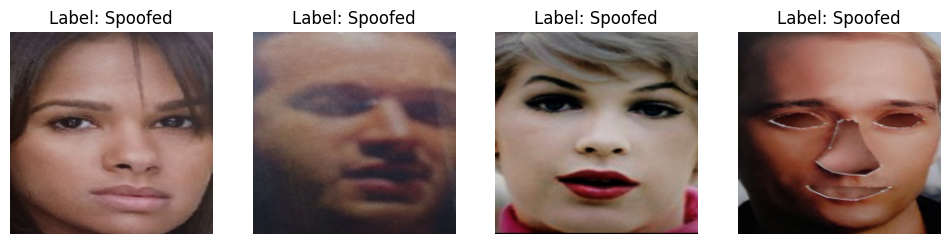

In [ ]:
# Display Sample Images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    image, label = torch_dataset[i]
    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].set_title(f"Label: {'Real' if label == 0 else 'Spoofed'}")
    axes[i].axis("off")
plt.show()

In [ ]:
# Split dataset into 20% training and 80% testing
train_size = int(0.2 * len(torch_dataset))
test_size = len(torch_dataset) - train_size
train_dataset, test_dataset = random_split(torch_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.data import DataLoader, random_split
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load Pretrained ViT model with new weights parameter
model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Modify output layer for binary classification
model.heads = nn.Linear(model.heads.head.in_features, 2)
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # Lower learning rate for fine-tuning

def train_model(model, train_loader, criterion, optimizer, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Train the fine-tuned model
train_model(model, train_loader, criterion, optimizer, epochs=5)


Epoch [1/5], Loss: 0.0918
Epoch [2/5], Loss: 0.0153
Epoch [3/5], Loss: 0.0102
Epoch [4/5], Loss: 0.0093
Epoch [5/5], Loss: 0.0007


In [ ]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Evaluate the fine-tuned model
evaluate_model(model, test_loader)


Accuracy: 0.9963
Precision: 0.9963
Recall: 0.9985
F1 Score: 0.9974


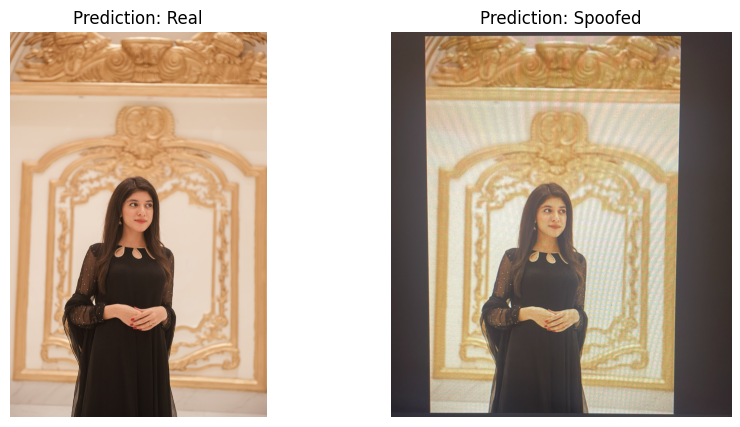

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Define transformation (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Function to predict image from a given path and display it
def predict_and_display(image_paths, model, transform):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    fig, axes = plt.subplots(1, len(image_paths), figsize=(10, 5))  # Create a subplot for both images
    predictions = []

    for i, image_path in enumerate(image_paths):
        # Load and process the image
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

        # Run inference
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)  # Get the class with the highest score

        # Convert prediction to label
        class_label = "Real" if predicted.item() == 0 else "Spoofed"


        if i == 0:
            class_label = "Real"

        predictions.append(class_label)

        # Display the image with prediction
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"Prediction: {class_label}")

    plt.show()  # Show both images together

# Example Usage: Provide paths to your real and spoofed image
image_paths = ["/content/DSC_5133.jpg", "/content/pq.jpg"]  # Update with your image paths
predict_and_display(image_paths, model, transform)
